In [1]:
%matplotlib inline
%config Completer.use_jedi = False

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [6]:
train_data = pd.read_excel("../../data/unzipped/Train.xlsx", skiprows=range(1,2), index_col=0)

In [7]:
train_data.head()

,"Диффузный индекс цен на выпускаемую продукцию, ожидаемые изменения","Диффузный индекс цен на покупаемую продукцию, ожидаемые изменения","Диффузный индекс заработной платы, ожидаемые изменения","Диффузный индекс занятости, ожидаемые изменения","Диффузный индекс выпуска, ожидаемые изменения","Диффузный индекс закупок оборудования, ожидаемые изменения","Диффузный индекс финансового состояния, ожидаемые изменения","Диффузный индекс портфеля заказов, ожидаемые изменения","Диффузный индекс задолженности банкам, ожидаемые изменения","Производство скота и птицы, тыс.тонн",...,"Среднемесячная пенсия, руб.",Реальная пенсия,MIACR,"Ставка по краткосрочным кредитам, население","Ставка по долгосрочным кредитам, население","Ставка по краткосрочным кредитам, фирмы","Ставка по долгосрочным кредитам, фирмы","Краткосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Долгосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Цена Urals, долл/бар"
2003m01,74,93,61,40,44,28,47,44,22,6.269096,...,7.288791,0.000000,6.331,21.5,18.9,14.5,17.3,6.993658,6.290272,3.383413
2003m02,78,95,66,37,49,30,53,56,18,6.320768,...,7.313953,0.008960,2.514,22.2,17.8,14.1,19.6,7.019476,6.298398,3.420624
2003m03,84,98,72,45,56,29,51,61,25,6.361302,...,7.314153,-0.001091,2.625,18.3,19.9,13.3,16.4,7.031299,6.325613,3.363693
2003m04,83,95,70,40,66,38,59,69,23,6.269096,...,7.382809,0.057178,1.888,20.0,21.3,13.4,14.9,7.048821,6.343001,3.130242
2003m05,79,94,76,43,66,33,63,68,23,6.177944,...,7.382809,0.049146,1.308,23.1,21.5,12.5,15.0,7.076400,6.371099,3.210488


In [10]:
train_data.values[:, 0]

array([74., 78., 84., 83., 79., 75., 74., 76., 74., 71., 77., 72., 80.,
       81., 85., 76., 73., 79., 74., 74., 69., 74., 73., 73., 79., 85.,
       81., 76., 73., 70., 67., 67., 69., 74., 70., 68., 77., 82., 79.,
       77., 69., 69., 67., 73., 73., 79., 74., 74., 80., 84., 85., 82.,
       73., 73., 75., 72., 78., 75., 79., 77., 82., 85., 89., 81., 81.,
       77., 74., 75., 74., 75., 72., 69., 67., 57., 57., 61., 58., 55.,
       53., 52., 53., 58., 55., 58., 64., 69., 67., 76., 64., 67., 65.,
       68., 66., 67., 66., 62., 75., 80., 84., 81., 71., 70., 67., 69.,
       71., 68., 67., 61., 67., 67., 74., 68., 63., 61., 64., 67., 66.,
       66., 63., 69., 70., 73., 75., 63., 68., 60., 57., 65., 64., 56.,
       55., 58., 64., 67., 69., 63., 58., 63., 63., 58., 63., 67., 63.,
       66., 81., 78., 85., 81., 74., 66., 60., 53., 60., 57., 65., 64.])

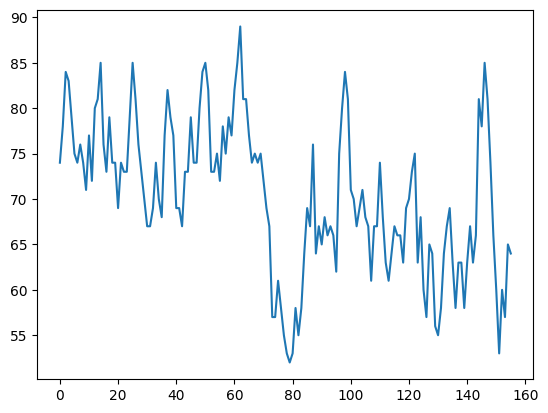

In [11]:
plt.plot(train_data.values[:, 0])

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [125]:
X = train_data.values[:, 0]

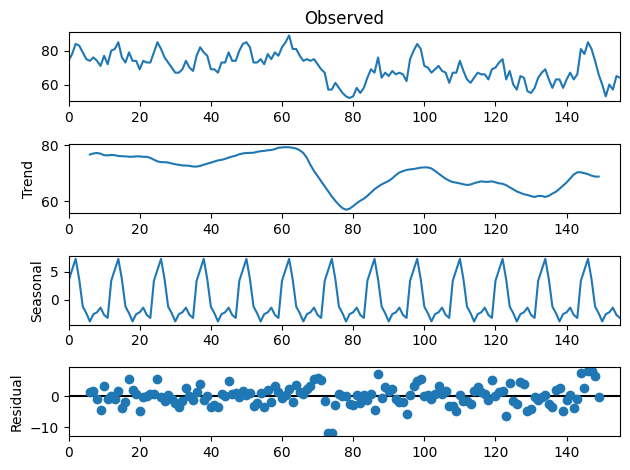

In [126]:
decompose_result = seasonal_decompose(X, model="additive", period=12)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

In [128]:
from sklearn.linear_model import LinearRegression

In [156]:
wo_seasons = X - seasonal
ids = np.arange(len(X)).reshape(-1,1)
trend_model = LinearRegression().fit(ids, wo_seasons)

In [158]:
trend_model.coef_, trend_model.intercept_

(array([-0.08832008]), 77.12044706775)

In [159]:
diff = wo_seasons - trend_model.predict(ids)

In [160]:
diff_norm = (diff - np.mean(diff)) / np.std(diff)

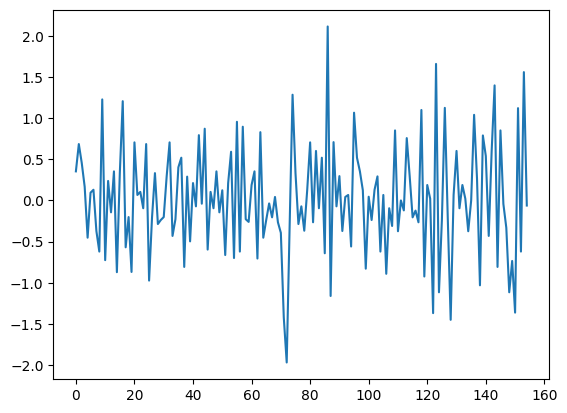

In [166]:
plt.plot(np.diff(diff_norm))

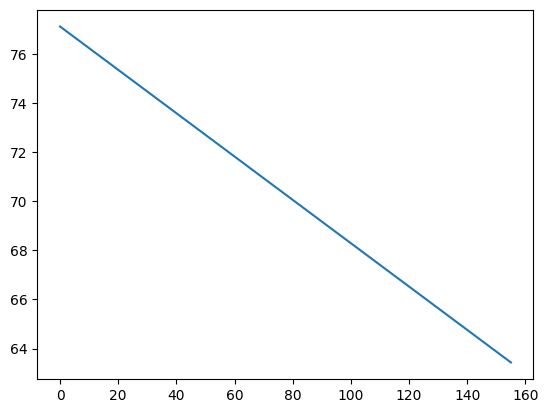

In [162]:
plt.plot(trend_model.predict(ids))

In [163]:
from statsmodels.tsa.stattools import adfuller

In [322]:
result = adfuller(diff_norm)

In [323]:
result

(-3.369446287684339,
 0.012045602952674067,
 1,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 274.0212710268156)

In [1846]:
def total(wmsfes):
    score = 0
    alpha = 12
    for m in wmsfes:
        score += (1.8 - 1.6 / (1 + np.exp(-alpha * m)))
    return score / len(wmsfes)


class Task:
    def __init__(self, history, orig, pred, period=12):
        assert period in [4,12]
        self.history = history
        self.orig = orig
        self.pred = pred
        self.period = period


def wmsfe(tasks):
    hm = np.array([len(t.orig) for t in tasks])
    km = np.sum(hm)
    scores = []
    for t in tasks:
        assert t.orig.shape == t.pred.shape
        disp = np.var(t.history[t.period:] - t.history[:-t.period])
        score = np.sum((t.orig - t.pred) ** 2 / (np.arange(len(t.pred)) + 1)) / disp
        scores.append(score)
    return np.sum(scores) / km, scores / hm

class TaskSet:
    def __init__(self):
        self.groups = []
        
    def buildFromTasks(self, tasks2d):
        for g in tasks2d:
            self.addGroup()
            for t in g:
                self.addTask(t)
        return self

    def addTask(self, task):
        self.groups[-1].append(task)

    def addGroup(self):
        self.groups.append([])

    def calcScore(self):
        losses = []
        for g in self.groups:
            loss, _ = wmsfe(g)
            losses.append(loss)
        return total(losses)
    

def leaderboard(tasks2d):
    return TaskSet().buildFromTasks(tasks2d).calcScore()

In [1840]:
window = 12 * 3

In [1841]:
def remove_nan_prefix(X):
    last_nan = np.max(list(np.where(np.isnan(X))[0]) + [-1])
    X = X[last_nan + 1:]
    return X

In [1844]:
class Normalizer:
    def __init__(self, period):
        self.period = period
    
    def transform(self, X):
        X = remove_nan_prefix(X)
        r = seasonal_decompose(X, model="additive", period=self.period)
        trend = X - r.seasonal
        
        mean = np.mean(trend)
        std = np.std(trend)
        trend_norm = (trend - mean) / std
        
        self.seasonal = r.seasonal
        self.mean = mean
        self.std = std
        self.trend_model = trend_model
        return trend_norm
    def inverse(self, X):
        X *= self.std
        X += self.mean
        seasons = np.tile(self.seasonal, len(X) // len(self.seasonal) + 1)[:len(X)]
        X += seasons
        return X

In [1826]:
class BaseModel:
    def fit(self, X, y):
        pass
    def predict(self, X):
        pass
    
class ZeroModel(BaseModel):
    def predict(self,_):
        return [0]

class LastConstModel(BaseModel):
    def predict(self, X):
        return [X[0][-1]]
    
class FirstConstModel(BaseModel):
    def __init__(self):
        self.const = None

    def predict(self, X):
        if self.const is None:
            self.const = X[0][-1]
        return [self.const]
    
class Weighted(BaseModel):
    def __init__(self, weights, base_model):
        self.weights = weights
        self.base_model = base_model
    def predict(self, X):
        return self.base_model.predict(X * self.weights)
    
class PredictWithDelta(BaseModel):
    def __init__(self, base_model):
        self.base_model = base_model
    def predict(self, X):
        y = self.base_model.predict(X)
        return X[:, -1] + y

In [1830]:
import tqdm

class SearchSequenceIndex:
    def __init__(self, window, period):
        self.window = window
        self.period = period
        
    def get_train_part_and_full(self, X, remove_prefix=0):
        offset = 15
        train_gap = offset + 12 + self.window
        X = X[remove_prefix:]
        T = X[:-train_gap]
        return T, X
    
    def build(self, X):
        assert len(X.shape) == 2
        self.X_normed = []

        for i in tqdm.tqdm(np.arange(X.shape[1]), position=0):
            x = X[:, i]
            x = Normalizer(self.period).transform(x)
            for j in range(len(x) - window - 1):
                sample = x[j:j + window + 1]
                self.X_normed.append(sample)
        self.X_normed = np.array(self.X_normed)
    
    def fit(self, base_model):
        self.base_model = base_model
        X_train = np.array([x[:-1] for x in self.X_normed])
        y_train = np.array([x[-1] - x[-2] for x in self.X_normed])
        self.base_model.fit(X_train, y_train)
        self.base_model = PredictWithDelta(self.base_model)
        
    def predict_for_seq(self, seq, steps):
        assert len(seq.shape) == 1, seq.shape[0] >= self.window + 1
        normalizer = Normalizer(self.period)
        seq = normalizer.transform(seq)
        for i in np.arange(steps):
            subSeq = seq[-window:]
            origSubSeq = subSeq
            x = subSeq.reshape(1,-1)
            y = self.base_model.predict(x)[0]
            subSeq = list(subSeq) + [y]
            assert np.mean((subSeq[:-1] - origSubSeq) ** 2) < 1e-6, (subSeq, origSubSeq)
            seq = np.append(seq, subSeq[-1])
        seq = normalizer.inverse(seq)
        return seq
    def measure_on_all_train_data(self, offset=15):
        mse = 0
        N = train_data.shape[1]
        tasks = []
        for t in np.arange(N):
            history = remove_nan_prefix(train_data.values[:, t])
            window_data = history[:-offset]
            r = index.predict_for_seq(window_data, offset)
            task = Task(window_data, history[-offset:], r[-offset:])
            tasks.append(task)
        return tasks

In [1831]:
index = SearchSequenceIndex(window=12 * 3, period=12)
train_seq, full_seq = index.get_train_part_and_full(train_data.values)
index.build(train_seq)

100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 1379.61it/s]


knn:  1.5238696422911238 0.3526681447366983
zero:  1.6253899642373788 0.3328912426003572
log z-test:  {'p_value': 0.08491798733255876, 'mu': 0.15954426198448432, 'sigma': 0.5929647846114491, 'win_rate': 0.5362318840579711}


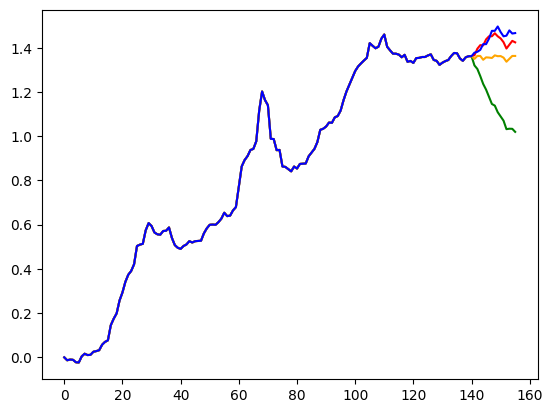

In [1848]:
T = 41
orig = train_data.values[:, T]
window_data = orig[:-offset]

index.fit(KNeighborsRegressor(n_neighbors=5))
r1 = index.predict_for_seq(window_data, offset)
knn_res = index.measure_on_all_train_data(offset=15)
knn_scores = wmsfe(knn_res)
print('knn: ', knn_scores[0], leaderboard([[x] for x in knn_res]))

index.fit(LinearRegression())
r2 = index.predict_for_seq(window_data, offset)

index.fit(ZeroModel())
r3 = index.predict_for_seq(window_data, offset)
zero_res = index.measure_on_all_train_data(offset=15)
zero_scores = wmsfe(zero_res)

print('zero: ', zero_scores[0], leaderboard([[x] for x in zero_res]))

print('log z-test: ', log_z_test(knn_scores[1], zero_scores[1]))

plt.plot(r1, 'red')
plt.plot(r2, 'green')
plt.plot(r3, 'orange')
plt.plot(train_data.values[:, T], 'blue')
plt.show()

In [1775]:
knn_model = KNeighborsRegressor(n_neighbors=5)
linear_model = LinearRegression()

In [1776]:
knn_weights = np.arange(window).reshape(1, -1) + 1

In [1777]:
X_normed = np.array(X_normed)
X_train = np.array([x[:-1] for x in X_normed])
y_train = np.array([x[-1] - x[-2] for x in X_normed])

In [1779]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [1780]:
X_train.shape, knn_weights.shape, (X_train * knn_weights).shape

((3768, 36), (1, 36), (3768, 36))

In [1781]:
v = X_train[0].reshape(1,-1) * knn_weights
v.shape

(1, 36)

In [1784]:
# from sklearn.manifold import TSNE
# tsne = TSNE(verbose=1)
# res = tsne.fit_transform(X_train)

In [1785]:
# plt.plot(res[:, 0], res[:,1], '*')

In [1788]:
from sklearn.metrics import r2_score, mean_squared_error

In [1790]:
from scipy.stats import norm

def p_val(x):
    return 2 * min(norm.cdf(-x), norm.cdf(x))

def log_z_test(res1, res2):
    res2 = np.log(res2)
    res1 = np.log(res1)
    delta = res2 - res1
    mu_z = np.mean(delta)
    sigma = np.std(delta)
    z = mu_z / sigma * T ** 0.5
    p = p_val(z)
    win_rate = np.mean(res1 <= res2) 
    return {"p_value":p, "mu": mu_z, "sigma": sigma, "win_rate": win_rate}

In [1795]:
taskSet = TaskSet()
taskSet.addFormatedTasks([[x] for x in knn_model_res])
taskSet.calcScore()

0.3526681447366983

In [1796]:
log_z_test(knn_model_scores, last_const_model_scores)

{'p_value': 0.0888121464382206,
 'mu': 0.15954426198448432,
 'sigma': 0.5929647846114491,
 'win_rate': 0.5362318840579711}

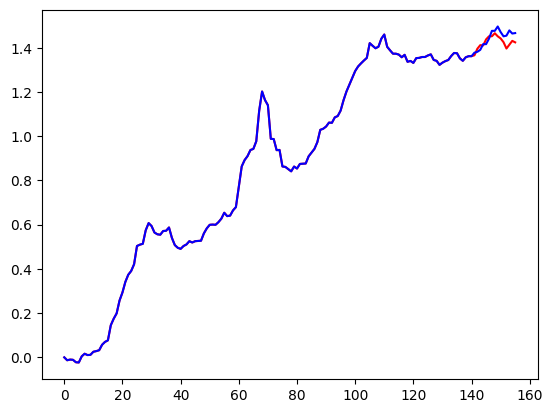

In [1815]:
T = 41
orig = train_data.values[:, T]
window_data = orig[:-offset]
r1 = index.predict_for_seq(window_data, offset)
# r2 = index.predict_for_seq(window_data, offset)
# r3 = index.predict_for_seq(window_data, offset)
plt.plot(r1, 'red')
# plt.plot(r2, 'green')
# plt.plot(r3, 'orange')
plt.plot(train_data.values[:, T], 'blue')
plt.show()